# Functional convergence analysis  

In [1]:
import pandas as pd
import seaborn as sns
import os 
import numpy as np
import matplotlib.pyplot as plt
from connectivity import weights as cweights
from connectivity import visualize as summary
from connectivity import data as cdata
import connectivity.constants as const
from statsmodels.stats.anova import AnovaRM
import scipy.stats as ss 

/Users/jdiedrichsen/.local/share/virtualenvs/cerebellum_connectivity-lV1BGCUV/lib/python3.7/site-packages/nilearn/datasets/__init__.py:89: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


In [2]:
# Import the relevant function from the scripts
import sys
sys.path.append('/Users/jdiedrichsen/Python/cerebellum_connectivity/connectivity/scripts')
from script_functional_convergence import *

## Matching criterion 
To judge whether the cerebellar parcels are matching cortical parcels, we are using a semi-non-negative matrix factorization on the response profiles for sc1 and sc2 combined. 
$$
Y=U^{+}V
$$
The decomposition uses an L1 penalty on the code (U). We are using dict_learning from sklearn as the basic learning mechanism. 

We then try to judge functional convergence by estimating the angle between the functional vectors extracted for regions A to all the vectors in a region B. Our evaluation criterion is taht we find the closest correspondence for each vector in A in B, and then average those maximal correlations across the vectors in A. Of course we can also evaluate the maximal correlation for each vector in A seperately. 

$$
vmatch = \frac{1}{N_A} \sum_i \max_j \mathbf{v}_{A,i}^T  \mathbf{v}_{B,j}
$$


### IID simulations

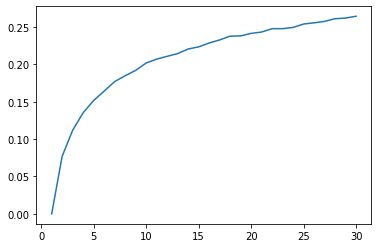

In [3]:
# This simulation shows that the average angle between items increases 
# as the number of vectors in the comparision group vmatch(A,B) increases 
kmax= 30
vm = np.empty((kmax,))
kk = np.arange(1,kmax+1)
for k in kk:
    vm[k-1] = vmatch_baseline([10,k],60)
plt.plot(kk,vm)


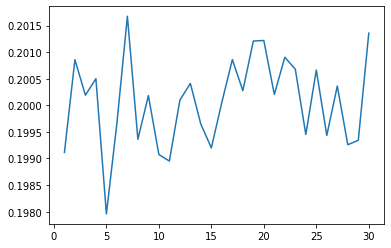

In [4]:
# The average angle is not influenced by the number of vectors 
# in the A group
kmax= 30
vm = np.empty((kmax,))
kk = np.arange(1,kmax+1)
for k in kk:
    vm[k-1] = vmatch_baseline([k,10],60)
plt.plot(kk,vm)


## Simulations with Gaussian data and different Covariance structures

## Overall correspondence between cerebellar and cortical reconstructions
We can now check the alignment between two structures by testing the alignment BETWEEN subjects either from one structure to itself. To account for the covariance matrix of each structure, we simulate data under the multivariate Gaussian with the empirical covariance matrix from the data.

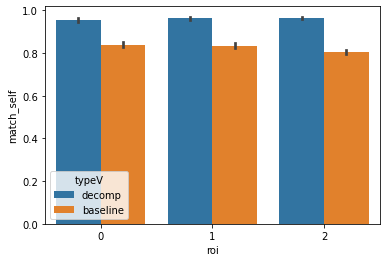

In [5]:
# We first inspect the average convergence alignment from different random starting locations
D=plot_match_self(roi=['cerebellum_suit','tessels1002','tessels1002'],
K=[10,10,17])
 

So we see a lot of more consistency of vectors one the real data compared to the basline simulation with a multivairate Gaussian. 

Next we are checking the alignment of the best fitting vector solution across subjects. 
To account for the overall covariance structure, we comparing again against the correlation to the vectors determined from the the Gaussian baseline simulation (with the same covariance structure). 

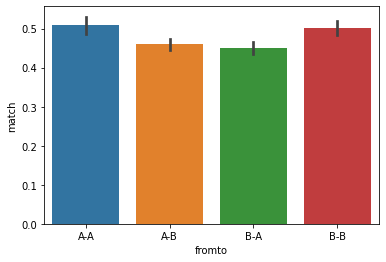

In [13]:
_= check_alignment_to_baseline(roi="cerebellum_suit",K=10)

0  t:1.65 p:0.113
1  t:-4.62 p:0.00012
2  t:-0.979 p:0.338
3  t:5.5 p:1.37e-05


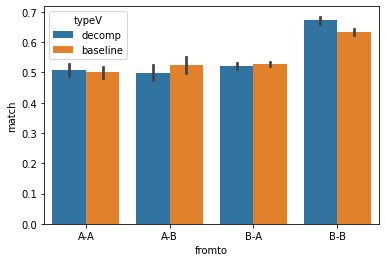

In [7]:
# Alignement cerebellum10 (A) to Cortex10 (B)
D= check_alignment(roi=["cerebellum_suit","tessels1002"],K=[10,10])

For the cortex, we have a very healthy better alignment for the vectors on the real data, as compared to the Gaussian artifical data. In the cerebellum, this effect is rather weak. Interestingly, the alignment of the cerebellar vectors to the real cortical data is worse than to the simulated Gaussian data. 

Looking at the cerebellar alignment of vectors in more detail: 

Text(0, 0.5, 'oberserved match')

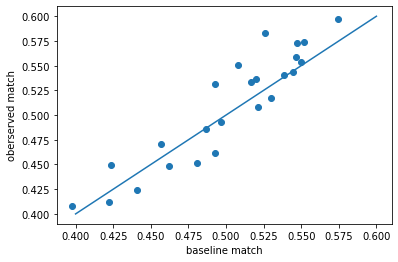

In [8]:
E=D[D['fromto']==0]
plt.scatter(E[E.typeV=='baseline'].match,E[E.typeV=='decomp'].match)
plt.plot([0.4,0.6],[0.4,0.6] )
plt.xlabel('baseline match')
plt.ylabel('oberserved match')

0  t:1.65 p:0.113
1  t:-4.84 p:6.91e-05
2  t:-0.276 p:0.785
3  t:5.62 p:1.02e-05


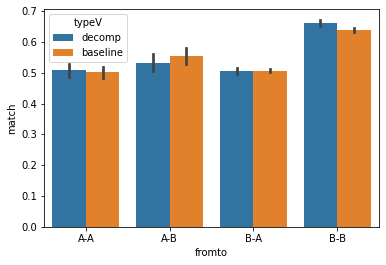

In [9]:
# Alignement cerebellum10 (A) to Cortex17 (B)
_=check_alignment(roi=["cerebellum_suit","tessels1002"],K=[10,17])

With the 17 regions in the cortex, we replicating again that the real data vectors are less corresponding to the cortical vectors, when compared to Gaussian simulation. In the next Figure, we can clearly see that this is the opposite for the cortical-cortical alignment (10 to 17). Does this interaction show evidence for an own functional parcellation in the cerebellum? 

0  t:5.5 p:1.37e-05
1  t:4.56 p:0.00014
2  t:4.0 p:0.000566
3  t:5.62 p:1.02e-05


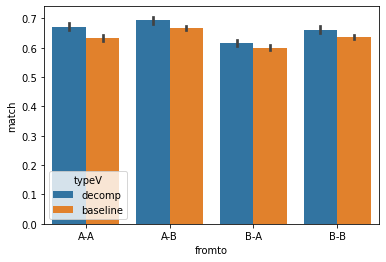

In [10]:
# Alignement cerebellum10 (A) to Cortex10 (B)
_=check_alignment(roi=["tessels1002","tessels1002"],K=[10,17])

## Region-by-region
In an attempt to do the alignment region-by-region, we extract the main vectors from the MDTB regions, and check their alignment to the cerebellar or cortical data of each subject. We can also check the alignment to the vectors determined on the Gaussian baseline simulation with the same covariance matrix (dashed line)

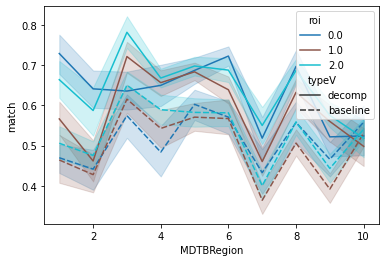

In [11]:
R=calc_alignment_by_region()

Alignment of these mean vectors to the individual cerebellar and cortical vectors is clearly better than for the corresponding Gaussian simulation. So that means that the MDTB parcellation is indeed reflecting the functional organisation over and above the RDM (second moment) across tasks.... 

On the other hand, most of the difference between regions seems to be dictated by where the vector of task specialization falls into the gaussian cloud of either the cerebellar or the cortical covariance structure. At this point, I just don't know enough about the lawful relationship correct for this. 

As a quick test, we can check the alignment of the MDTB vectors to the real cerebellar compared to the fake cerebellar vectors, which is super-highly significant. 

In [12]:
D=R[R.rname=='cerebellum_suit']
A=pd.pivot_table(D,values='match',index=D.subjn,columns=D.typeV,aggfunc=np.mean)

t,p=ss.ttest_rel(A.baseline,A.decomp)

print(f"t:{t:.3} p:{p:.3}")


t:-13.0 p:4.38e-12
